In [11]:
!pip install pycocotools matplotlib opencv-python tqdm scikit-learn

In [12]:
# Cellule 2: Importations
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random

In [13]:
# Cellule 1: Exploration de la structure des dossiers
import os
import glob

# Afficher le répertoire de travail actuel
current_dir = os.getcwd()
print(f"Répertoire de travail actuel: {current_dir}")

# Vérifier le contenu du répertoire parent
parent_dir = os.path.dirname(current_dir)
print(f"Répertoire parent: {parent_dir}")
print("Contenu du répertoire parent:")
for item in os.listdir(parent_dir):
    if os.path.isdir(os.path.join(parent_dir, item)):
        print(f"  - Dossier: {item}")
    else:
        print(f"  - Fichier: {item}")

# Vérifier si le dossier coco existe et son contenu
coco_dir = os.path.join(parent_dir, 'coco')
if os.path.exists(coco_dir):
    print(f"\nLe dossier coco existe à: {coco_dir}")
    print("Contenu du dossier coco:")
    for item in os.listdir(coco_dir):
        if os.path.isdir(os.path.join(coco_dir, item)):
            print(f"  - Dossier: {item}")
        else:
            print(f"  - Fichier: {item}")
else:
    print(f"\nLe dossier coco n'a pas été trouvé à: {coco_dir}")
    
    # Chercher le dossier coco dans les sous-répertoires
    print("\nRecherche du dossier coco dans l'arborescence...")
    found_coco = []
    for root, dirs, files in os.walk(parent_dir):
        if 'coco' in dirs:
            found_coco.append(os.path.join(root, 'coco'))
    
    if found_coco:
        print(f"Dossiers 'coco' trouvés:")
        for path in found_coco:
            print(f"  - {path}")
    else:
        print("Aucun dossier 'coco' trouvé dans l'arborescence")
        
        # Chercher des dossiers avec des noms similaires
        print("\nRecherche de dossiers avec des noms contenant 'coco'...")
        found = []
        for root, dirs, files in os.walk(parent_dir):
            for d in dirs:
                if 'coco' in d.lower():
                    found.append(os.path.join(root, d))
        
        if found:
            print(f"Dossiers trouvés:")
            for path in found:
                print(f"  - {path}")
        else:
            print("Aucun dossier avec 'coco' dans le nom n'a été trouvé")

# Chercher les fichiers d'annotations
print("\nRecherche des fichiers d'annotations de COCO...")
annotations = []
for root, dirs, files in os.walk(parent_dir):
    for file in files:
        if 'instances_train2017.json' in file or 'instances_val2017.json' in file:
            annotations.append(os.path.join(root, file))

if annotations:
    print("Fichiers d'annotations trouvés:")
    for path in annotations:
        print(f"  - {path}")
else:
    print("Aucun fichier d'annotations de COCO trouvé")

# Chercher les dossiers d'images
print("\nRecherche des dossiers d'images de COCO...")
image_dirs = []
for root, dirs, files in os.walk(parent_dir):
    if 'train2017' in dirs or 'val2017' in dirs:
        if 'train2017' in dirs:
            image_dirs.append(os.path.join(root, 'train2017'))
        if 'val2017' in dirs:
            image_dirs.append(os.path.join(root, 'val2017'))

if image_dirs:
    print("Dossiers d'images trouvés:")
    for path in image_dirs:
        print(f"  - {path}")
else:
    print("Aucun dossier d'images de COCO trouvé")

Répertoire de travail actuel: c:\Users\ay855\Documents\detction_model
Répertoire parent: c:\Users\ay855\Documents
Contenu du répertoire parent:
  - Dossier: cimpiler
  - Fichier: cv.md
  - Fichier: desktop.ini
  - Dossier: detction_model
  - Dossier: ITAL
  - Fichier: ITAL (2).zip
  - Fichier: ITAL.zip
  - Dossier: KONAMI
  - Dossier: Ma musique
  - Fichier: Madame.docx
  - Dossier: Mes images
  - Dossier: Mes vidéos
  - Dossier: Modèles Office personnalisés
  - Fichier: presentation_ital.pdf
  - Fichier: presentation_ital.pptx
  - Dossier: reseau tst
  - Dossier: tp5
  - Dossier: venv
  - Dossier: WindowsPowerShell
  - Dossier: XuanZhi9
  - Fichier: ~$Madame.docx

Le dossier coco n'a pas été trouvé à: c:\Users\ay855\Documents\coco

Recherche du dossier coco dans l'arborescence...
Dossiers 'coco' trouvés:
  - c:\Users\ay855\Documents\detction_model\coco

Recherche des fichiers d'annotations de COCO...
Fichiers d'annotations trouvés:
  - c:\Users\ay855\Documents\detction_model\coco\anno

In [19]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2
from tqdm import tqdm

# Définissez manuellement les chemins en fonction de votre structure
# Exemple:
COCO_DIR = 'c:/Users/ay855/Documents/detction_model/coco'  # Ajustez selon votre structure

# Chemins des annotations
TRAIN_ANN_PATH = os.path.join(COCO_DIR, 'annotations', 'instances_train2017.json')
VAL_ANN_PATH = os.path.join(COCO_DIR, 'annotations', 'instances_val2017.json')

# Chemins des images
TRAIN_IMG_DIR = os.path.join(COCO_DIR, 'images','train2017')  # Possible structure alternative
VAL_IMG_DIR = os.path.join(COCO_DIR, 'images', 'val2017')  # Possible structure alternative


In [20]:
# Vérifier que les chemins sont corrects
print(f"TRAIN_ANN_PATH: {TRAIN_ANN_PATH}")
print(f"VAL_ANN_PATH: {VAL_ANN_PATH}")
print(f"TRAIN_IMG_DIR: {TRAIN_IMG_DIR}")
print(f"VAL_IMG_DIR: {VAL_IMG_DIR}")

# Vérifier que les fichiers existent
print(f"Le fichier d'annotations d'entraînement existe: {os.path.exists(TRAIN_ANN_PATH)}")
print(f"Le fichier d'annotations de validation existe: {os.path.exists(VAL_ANN_PATH)}")
print(f"Le dossier d'images d'entraînement existe: {os.path.exists(TRAIN_IMG_DIR)}")
print(f"Le dossier d'images de validation existe: {os.path.exists(VAL_IMG_DIR)}")

TRAIN_ANN_PATH: c:/Users/ay855/Documents/detction_model/coco\annotations\instances_train2017.json
VAL_ANN_PATH: c:/Users/ay855/Documents/detction_model/coco\annotations\instances_val2017.json
TRAIN_IMG_DIR: c:/Users/ay855/Documents/detction_model/coco\images\train2017
VAL_IMG_DIR: c:/Users/ay855/Documents/detction_model/coco\images\val2017
Le fichier d'annotations d'entraînement existe: True
Le fichier d'annotations de validation existe: True
Le dossier d'images d'entraînement existe: True
Le dossier d'images de validation existe: True


In [21]:
# Cellule 3: Chargement des annotations COCO
train_coco = COCO(TRAIN_ANN_PATH)
val_coco = COCO(VAL_ANN_PATH)

# Afficher la structure du dataset
print("\nStructure du dataset COCO:")
print(f"Nombre d'images d'entraînement: {len(train_coco.imgs)}")
print(f"Nombre d'images de validation: {len(val_coco.imgs)}")
print(f"Nombre d'annotations d'entraînement: {len(train_coco.anns)}")
print(f"Nombre d'annotations de validation: {len(val_coco.anns)}")

# Afficher toutes les catégories disponibles
cats = train_coco.loadCats(train_coco.getCatIds())
cat_names = sorted([cat['name'] for cat in cats])
print(f"\nNombre total de catégories COCO: {len(cat_names)}")
print("Catégories disponibles:")
for i, name in enumerate(cat_names):
    print(f"{i+1:3d}. {name}")

loading annotations into memory...
Done (t=13.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!

Structure du dataset COCO:
Nombre d'images d'entraînement: 118287
Nombre d'images de validation: 5000
Nombre d'annotations d'entraînement: 860001
Nombre d'annotations de validation: 36781

Nombre total de catégories COCO: 80
Catégories disponibles:
  1. airplane
  2. apple
  3. backpack
  4. banana
  5. baseball bat
  6. baseball glove
  7. bear
  8. bed
  9. bench
 10. bicycle
 11. bird
 12. boat
 13. book
 14. bottle
 15. bowl
 16. broccoli
 17. bus
 18. cake
 19. car
 20. carrot
 21. cat
 22. cell phone
 23. chair
 24. clock
 25. couch
 26. cow
 27. cup
 28. dining table
 29. dog
 30. donut
 31. elephant
 32. fire hydrant
 33. fork
 34. frisbee
 35. giraffe
 36. hair drier
 37. handbag
 38. horse
 39. hot dog
 40. keyboard
 41. kite
 42. knife
 43. laptop
 44. microwave
 45. motorcycle
 46. mouse
 47. orange
 48. oven

In [22]:
# Cellule 4: Définir et filtrer les classes d'intérêt
# Définir les classes d'intérêt pour les objets perdus
CLASSES_OF_INTEREST = [
    'backpack',       # sac à dos
    'suitcase',       # valise
    'handbag',        # sac à main
    'cell phone',     # téléphone portable
    'laptop',         # ordinateur portable
    'book',           # livre
    'umbrella',       # parapluie
    'bottle',         # bouteille
    'keyboard',       # clavier
    'remote',         # télécommande
    'wallet'          # portefeuille (peut ne pas exister dans COCO)
]

# Vérifier quelles classes existent réellement dans COCO
existing_classes = []
class_ids = []

for cls in CLASSES_OF_INTEREST:
    cat_ids = train_coco.getCatIds(catNms=[cls])
    if cat_ids:
        existing_classes.append(cls)
        class_ids.append(cat_ids[0])
    else:
        print(f"Classe '{cls}' non trouvée dans COCO")

print(f"\nClasses disponibles dans COCO ({len(existing_classes)}/{len(CLASSES_OF_INTEREST)}):")
for i, cls in enumerate(existing_classes):
    print(f"{i+1}. {cls} (ID: {class_ids[i]})")

# Créer un mapping d'indices pour notre propre modèle
class_to_idx = {cls: idx for idx, cls in enumerate(existing_classes)}
idx_to_class = {idx: cls for idx, cls in enumerate(existing_classes)}

Classe 'wallet' non trouvée dans COCO

Classes disponibles dans COCO (10/11):
1. backpack (ID: 27)
2. suitcase (ID: 33)
3. handbag (ID: 31)
4. cell phone (ID: 77)
5. laptop (ID: 73)
6. book (ID: 84)
7. umbrella (ID: 28)
8. bottle (ID: 44)
9. keyboard (ID: 76)
10. remote (ID: 75)


In [23]:
# Cellule 5: Trouver toutes les images contenant nos objets d'intérêt
# Fonction pour trouver les images contenant des objets spécifiques
def find_images_with_objects(coco, class_ids):
    """Trouve toutes les images contenant au moins un objet des classes spécifiées"""
    img_ids = set()  # Utiliser un set pour éviter les doublons
    
    # Pour chaque classe d'intérêt
    for class_id in class_ids:
        # Trouver toutes les images contenant cette classe
        ids = coco.getImgIds(catIds=[class_id])
        img_ids.update(ids)
    
    return sorted(list(img_ids))

# Trouver les images d'entraînement et de validation
train_img_ids = find_images_with_objects(train_coco, class_ids)
val_img_ids = find_images_with_objects(val_coco, class_ids)

print(f"\nNombre d'images d'entraînement contenant nos objets d'intérêt: {len(train_img_ids)}")
print(f"Nombre d'images de validation contenant nos objets d'intérêt: {len(val_img_ids)}")

# Afficher quelques exemples d'IDs d'images
print("\nExemples d'IDs d'images d'entraînement:")
print(train_img_ids[:10])


Nombre d'images d'entraînement contenant nos objets d'intérêt: 32075
Nombre d'images de validation contenant nos objets d'intérêt: 1399

Exemples d'IDs d'images d'entraînement:
[36, 86, 89, 127, 142, 164, 241, 257, 260, 283]


In [24]:
# Cellule 6: Analyse de la distribution des objets par classe
# Calculer le nombre d'instances par classe
class_counts = {cls: 0 for cls in existing_classes}
object_sizes = {cls: [] for cls in existing_classes}
instances_per_image = []

# Fonction pour analyser la distribution dans un ensemble de données
def analyze_distribution(coco, img_ids, class_ids):
    """Analyse la distribution des objets dans l'ensemble de données"""
    class_counts = {coco.loadCats([cat_id])[0]['name']: 0 for cat_id in class_ids}
    object_sizes = {coco.loadCats([cat_id])[0]['name']: [] for cat_id in class_ids}
    instances_per_image = []
    
    # Pour chaque image
    for img_id in tqdm(img_ids, desc="Analysing object distribution"):
        # Récupérer les annotations pour cette image
        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=class_ids)
        anns = coco.loadAnns(ann_ids)
        
        # Compter les instances de cette image
        instances_per_image.append(len(anns))
        
        # Pour chaque annotation
        for ann in anns:
            cat_id = ann['category_id']
            if cat_id in class_ids:
                cls = coco.loadCats([cat_id])[0]['name']
                
                # Incrémenter le compteur de classe
                class_counts[cls] += 1
                
                # Calculer la taille de l'objet (surface du bbox)
                bbox = ann['bbox']  # [x, y, width, height]
                area = bbox[2] * bbox[3]
                object_sizes[cls].append(area)
    
    return class_counts, object_sizes, instances_per_image

# Analyser les données d'entraînement
print("\nAnalyse de la distribution des objets dans l'ensemble d'entraînement...")
train_class_counts, train_object_sizes, train_instances_per_image = analyze_distribution(
    train_coco, train_img_ids, class_ids)

# Analyser les données de validation
print("\nAnalyse de la distribution des objets dans l'ensemble de validation...")
val_class_counts, val_object_sizes, val_instances_per_image = analyze_distribution(
    val_coco, val_img_ids, class_ids)

# Afficher les statistiques
print("\nNombre d'instances par classe dans l'ensemble d'entraînement:")
for cls, count in sorted(train_class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls}: {count} instances")

# Calculer les statistiques de taille
print("\nStatistiques de taille des objets (en pixels²) dans l'ensemble d'entraînement:")
for cls, sizes in train_object_sizes.items():
    if sizes:
        print(f"{cls}: min={np.min(sizes):.1f}, moyenne={np.mean(sizes):.1f}, max={np.max(sizes):.1f}, count={len(sizes)}")


Analyse de la distribution des objets dans l'ensemble d'entraînement...


Analysing object distribution: 100%|██████████| 32075/32075 [00:00<00:00, 54369.03it/s]



Analyse de la distribution des objets dans l'ensemble de validation...


Analysing object distribution: 100%|██████████| 1399/1399 [00:00<00:00, 81846.64it/s]


Nombre d'instances par classe dans l'ensemble d'entraînement:
book: 24715 instances
bottle: 24342 instances
handbag: 12354 instances
umbrella: 11431 instances
backpack: 8720 instances
cell phone: 6434 instances
suitcase: 6192 instances
remote: 5703 instances
laptop: 4970 instances
keyboard: 2855 instances

Statistiques de taille des objets (en pixels²) dans l'ensemble d'entraînement:
backpack: min=3.3, moyenne=6856.3, max=303763.2, count=8720
suitcase: min=13.8, moyenne=26255.5, max=388639.8, count=6192
handbag: min=3.3, moyenne=5749.0, max=305369.6, count=12354
cell phone: min=1.7, moyenne=8519.9, max=305606.4, count=6434
laptop: min=7.7, moyenne=39638.3, max=396830.6, count=4970
book: min=4.9, moyenne=5932.8, max=388542.0, count=24715
umbrella: min=8.0, moyenne=17625.3, max=404076.8, count=11431
bottle: min=6.7, moyenne=4451.3, max=304164.0, count=24342
keyboard: min=31.3, moyenne=24034.5, max=307200.0, count=2855
remote: min=3.7, moyenne=5914.2, max=372938.2, count=5703


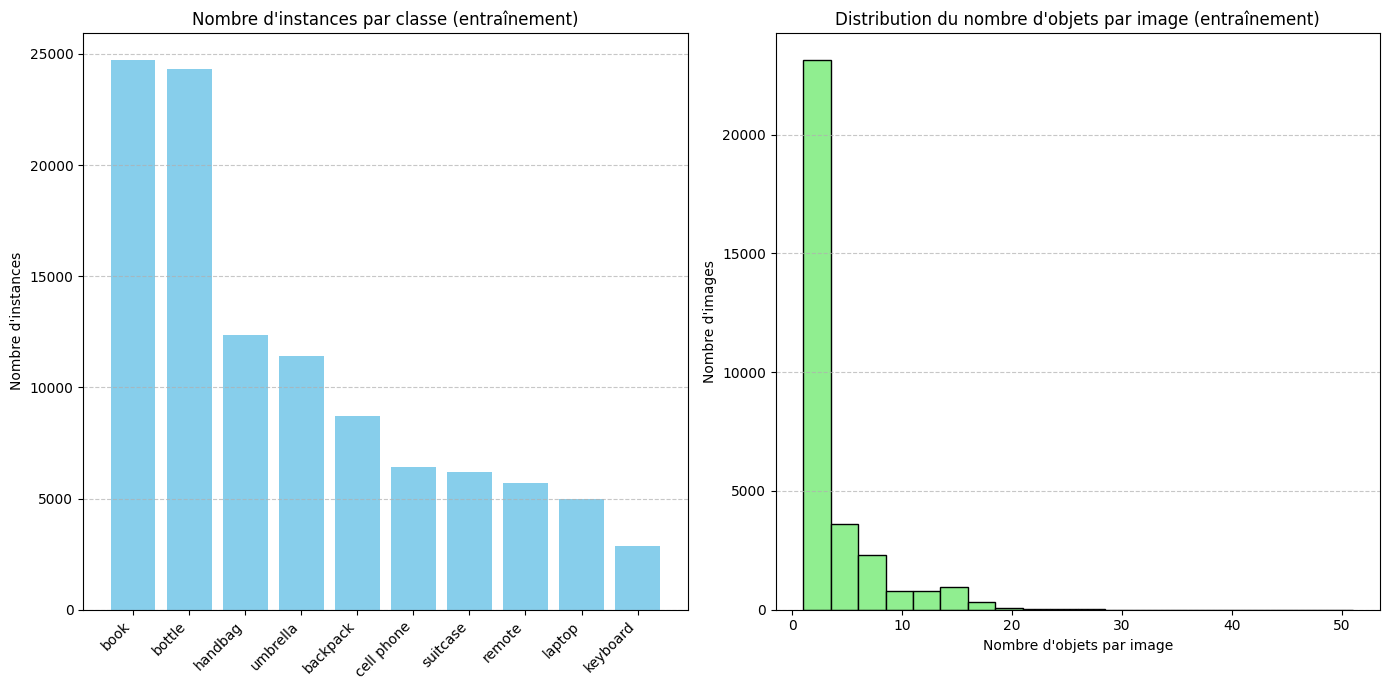

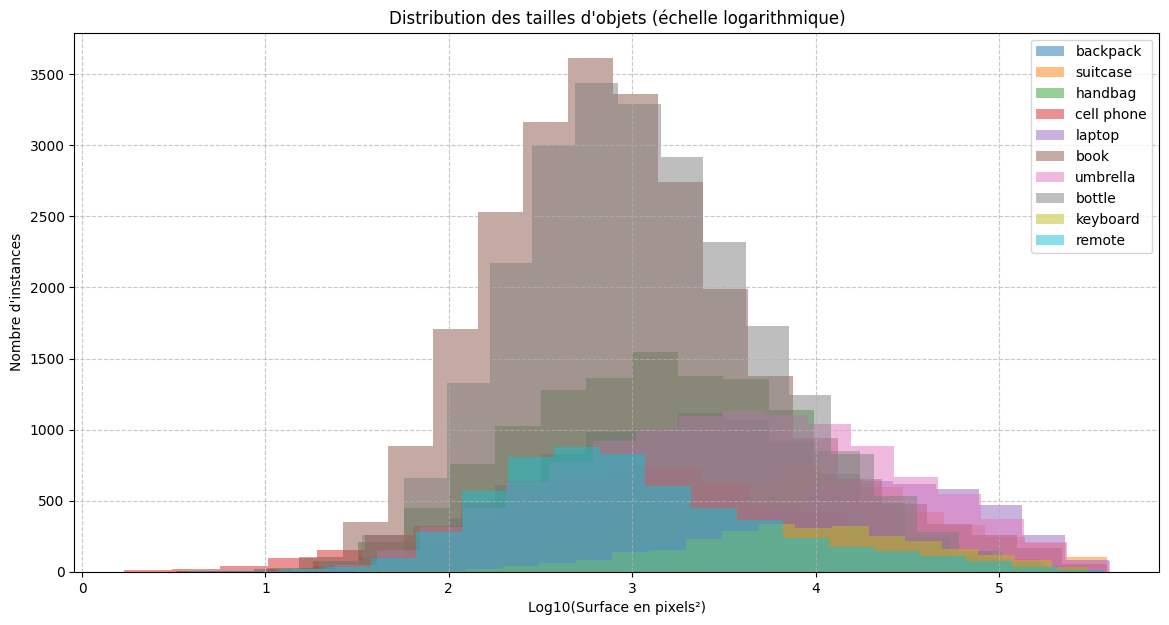

In [25]:
# Cellule 7: Visualisation de la distribution des classes
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
classes = list(train_class_counts.keys())
counts = list(train_class_counts.values())
# Trier par nombre d'instances
sorted_indices = np.argsort(counts)[::-1]  # ordre décroissant
classes = [classes[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

plt.bar(classes, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Nombre d\'instances par classe (entraînement)')
plt.ylabel('Nombre d\'instances')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Distribution des objets par image
plt.subplot(1, 2, 2)
plt.hist(train_instances_per_image, bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution du nombre d\'objets par image (entraînement)')
plt.xlabel('Nombre d\'objets par image')
plt.ylabel('Nombre d\'images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# Visualisation de la taille des objets
plt.figure(figsize=(14, 7))
for cls in existing_classes:
    if train_object_sizes[cls]:
        # Utiliser une échelle logarithmique pour mieux visualiser
        sizes = np.log10(train_object_sizes[cls])
        plt.hist(sizes, bins=20, alpha=0.5, label=cls)

plt.title('Distribution des tailles d\'objets (échelle logarithmique)')
plt.xlabel('Log10(Surface en pixels²)')
plt.ylabel('Nombre d\'instances')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('size_distribution.png')
plt.show()

In [26]:
# Cellule 9: Création des ensembles train/val/test
# Nous avons déjà train_img_ids et val_img_ids

# Option 1: Garder l'ensemble de train COCO comme notre train,
# et diviser l'ensemble val COCO en notre val et test
final_train_img_ids = train_img_ids

# Diviser l'ensemble de validation COCO en validation et test (70% val, 30% test)
final_val_img_ids, final_test_img_ids = train_test_split(
    val_img_ids, test_size=0.3, random_state=42)


print(f"\nDivision finale des données:")
print(f"Train: {len(final_train_img_ids)} images")
print(f"Validation: {len(final_val_img_ids)} images")
print(f"Test: {len(final_test_img_ids)} images")


Division finale des données:
Train: 32075 images
Validation: 979 images
Test: 420 images


In [27]:
# Cellule 10: Définition du Dataset personnalisé pour PyTorch
class LostObjectsDataset(Dataset):
    """Dataset personnalisé pour la détection d'objets perdus"""
    
    def __init__(self, coco, img_ids, img_dir, class_ids, transform=None):
        self.coco = coco
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.class_ids = class_ids
        self.transform = transform
        
        # Mapping de catégories COCO vers nos indices
        self.cat_mapping = {cat_id: i for i, cat_id in enumerate(class_ids)}
    
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        # Obtenir l'ID de l'image
        img_id = self.img_ids[idx]
        
        # Charger les informations de l'image
        img_info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Charger l'image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Dimensions de l'image
        height, width = img.shape[:2]
        
        # Récupérer les annotations
        ann_ids = self.coco.getAnnIds(imgIds=[img_id], catIds=self.class_ids)
        anns = self.coco.loadAnns(ann_ids)
        
        # Préparer les boîtes et classes
        boxes = []
        labels = []
        
        for ann in anns:
            cat_id = ann['category_id']
            if cat_id in self.class_ids:
                # Convertir le bbox [x, y, width, height] en [x1, y1, x2, y2]
                bbox = ann['bbox']
                x1, y1, w, h = bbox
                x2, y2 = x1 + w, y1 + h
                
                # S'assurer que les coordonnées sont dans les limites de l'image
                x1 = max(0, min(x1, width - 1))
                y1 = max(0, min(y1, height - 1))
                x2 = max(0, min(x2, width - 1))
                y2 = max(0, min(y2, height - 1))
                
                # Vérifier que la boîte est valide (largeur et hauteur > 0)
                if x2 > x1 and y2 > y1:
                    # Normaliser les coordonnées entre 0 et 1
                    x1 /= width
                    y1 /= height
                    x2 /= width
                    y2 /= height
                    
                    boxes.append([x1, y1, x2, y2])
                    labels.append(self.cat_mapping[cat_id])
        
        # Convertir en tenseurs
        if boxes:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        else:
            # Si aucune boîte valide, créer des tenseurs vides
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0), dtype=torch.int64)
        
        # Identifiant de l'image pour référence
        image_id = torch.tensor([img_id])
        
        # Surface des boîtes
        if len(boxes) > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.zeros((0), dtype=torch.float32)
        
        # Supposons que tous les objets sont visibles (pas d'occultation)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        
        # Créer le dictionnaire cible
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }
        
        # Appliquer les transformations
        if self.transform:
            # Note: Pour une détection d'objets propre, vous devrez utiliser une
            # bibliothèque qui gère la transformation des boîtes aussi (comme albumentations)
            img = self.transform(img)
        
        return img, target

# Fonction de collation pour gérer les lots d'images de tailles différentes
def collate_fn(batch):
    return tuple(zip(*batch))

In [28]:
# Cellule 11: Définition des transformations et création des DataLoaders
# Définir les transformations pour l'augmentation de données
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Création des datasets
train_dataset = LostObjectsDataset(
    train_coco, 
    final_train_img_ids,
    TRAIN_IMG_DIR,
    class_ids,
    transform=train_transform
)

val_dataset = LostObjectsDataset(
    val_coco, 
    final_val_img_ids,
    VAL_IMG_DIR,
    class_ids,
    transform=val_transform
)

test_dataset = LostObjectsDataset(
    val_coco, 
    final_test_img_ids,
    VAL_IMG_DIR,
    class_ids,
    transform=val_transform
)

# Création des DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Ajustez selon votre mémoire GPU
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2  # Ajustez selon votre CPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

In [29]:
# Cellule 13: Sauvegarde de la configuration pour l'entraînement
# Créer un dossier pour les sorties
OUTPUT_DIR = os.path.join(COCO_DIR, 'lost_objects_output')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Récapitulatif des statistiques des données pour référence future
data_summary = {
    'classes': existing_classes,
    'class_ids': class_ids,
    'class_to_idx': class_to_idx,
    'idx_to_class': {str(k): v for k, v in idx_to_class.items()},  # Convertir les clés en string pour JSON
    'num_classes': len(existing_classes),
    'train_count': len(final_train_img_ids),
    'val_count': len(final_val_img_ids),
    'test_count': len(final_test_img_ids),
    'class_distribution': {
        'train': {cls: train_class_counts.get(cls, 0) for cls in existing_classes},
        'val': {cls: val_class_counts.get(cls, 0) for cls in existing_classes}
    }
}

# Sauvegarder la configuration
with open(os.path.join(OUTPUT_DIR, 'dataset_config.json'), 'w') as f:
    json.dump(data_summary, f, indent=4)

print(f"Configuration du dataset sauvegardée dans {os.path.join(OUTPUT_DIR, 'dataset_config.json')}")

# Sauvegarder les IDs d'images pour chaque ensemble (pour référence)
np.save(os.path.join(OUTPUT_DIR, 'train_img_ids.npy'), final_train_img_ids)
np.save(os.path.join(OUTPUT_DIR, 'val_img_ids.npy'), final_val_img_ids)
np.save(os.path.join(OUTPUT_DIR, 'test_img_ids.npy'), final_test_img_ids)

print(f"IDs d'images sauvegardés dans {OUTPUT_DIR}")

Configuration du dataset sauvegardée dans c:/Users/ay855/Documents/detction_model/coco\lost_objects_output\dataset_config.json
IDs d'images sauvegardés dans c:/Users/ay855/Documents/detction_model/coco\lost_objects_output


In [30]:
# Cellule 14: Résumé final
print("\n===== RÉSUMÉ DE LA PRÉPARATION DES DONNÉES =====")
print(f"Classes d'objets perdus: {', '.join(existing_classes)}")
print(f"Nombre de classes: {len(existing_classes)}")
print(f"Taille du dataset d'entraînement: {len(train_dataset)} images")
print(f"Taille du dataset de validation: {len(val_dataset)} images")
print(f"Taille du dataset de test: {len(test_dataset)} images")

# Afficher le nombre total d'instances par classe
print("\nNombre total d'instances par classe:")
for cls in existing_classes:
    train_count = train_class_counts.get(cls, 0)
    val_count = val_class_counts.get(cls, 0)
    total_count = train_count + val_count
    print(f"{cls}: {total_count} instances (train: {train_count}, val: {val_count})")

print("\nLa préparation des données est terminée. Vous êtes prêt pour l'étape suivante: la conception de l'architecture du modèle.")


===== RÉSUMÉ DE LA PRÉPARATION DES DONNÉES =====
Classes d'objets perdus: backpack, suitcase, handbag, cell phone, laptop, book, umbrella, bottle, keyboard, remote
Nombre de classes: 10
Taille du dataset d'entraînement: 32075 images
Taille du dataset de validation: 979 images
Taille du dataset de test: 420 images

Nombre total d'instances par classe:
backpack: 9091 instances (train: 8720, val: 371)
suitcase: 6495 instances (train: 6192, val: 303)
handbag: 12894 instances (train: 12354, val: 540)
cell phone: 6696 instances (train: 6434, val: 262)
laptop: 5201 instances (train: 4970, val: 231)
book: 25876 instances (train: 24715, val: 1161)
umbrella: 11844 instances (train: 11431, val: 413)
bottle: 25367 instances (train: 24342, val: 1025)
keyboard: 3008 instances (train: 2855, val: 153)
remote: 5986 instances (train: 5703, val: 283)

La préparation des données est terminée. Vous êtes prêt pour l'étape suivante: la conception de l'architecture du modèle.
